In [1]:
import torch
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from DatasetFetcher import DatasetFetcher
from project1_model import ResNet, BasicBlock 

In [2]:
# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fetching Dataset
df = DatasetFetcher(dataset="CIFAR10", batch_size=64)
df.addHorizontalFlipping()
df.addRandomCrop(size=32, padding=3)
df.addNormalizer()
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Get Model
model = ResNet(BasicBlock, 3, [2, 2, 2])
model = model.to(device)
#print(summary(model))

In [4]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer) 
lossFunction = torch.nn.CrossEntropyLoss()
learningRate = 0.001
weightDecay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [5]:
# Setting up training
EPOCHS=100
globalBestAccuracy = 0.0
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [6]:
# Training
for i in tqdm(range(EPOCHS)):
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model.train()
            optimizer.zero_grad()
        else:
            loader = testLoader
            model.eval()
        runningLoss = 0.0
        runningCorrects = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = lossFunction(output, labels)
            predicted_labels = torch.argmax(output, dim=1)
            runningLoss = loss.item()*images.size(0)
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))

  1%|          | 1/100 [00:16<27:48, 16.86s/it]

Training Loss : 0.0006963887023925782, Testing Loss : 0.003073107719421387, Training Accuracy : 0.12692, Testing Accuracy : 0.1606


  2%|▏         | 2/100 [00:33<27:26, 16.80s/it]

Training Loss : 0.0007983326721191406, Testing Loss : 0.0028271678924560546, Training Accuracy : 0.19404, Testing Accuracy : 0.2273


  3%|▎         | 3/100 [00:50<27:02, 16.73s/it]

Training Loss : 0.0006300061416625977, Testing Loss : 0.0027529148101806643, Training Accuracy : 0.20366, Testing Accuracy : 0.2103


  4%|▍         | 4/100 [01:06<26:42, 16.69s/it]

Training Loss : 0.0006294543075561523, Testing Loss : 0.0029813995361328127, Training Accuracy : 0.1983, Testing Accuracy : 0.2179


  5%|▌         | 5/100 [01:23<26:26, 16.70s/it]

Training Loss : 0.0007561128234863281, Testing Loss : 0.002772895431518555, Training Accuracy : 0.21026, Testing Accuracy : 0.2045


  6%|▌         | 6/100 [01:40<26:08, 16.69s/it]

Training Loss : 0.0005763017272949219, Testing Loss : 0.0033304744720458984, Training Accuracy : 0.20744, Testing Accuracy : 0.1961


  7%|▋         | 7/100 [01:56<25:51, 16.68s/it]

Training Loss : 0.0006666091918945313, Testing Loss : 0.003032081413269043, Training Accuracy : 0.21576, Testing Accuracy : 0.199


  8%|▊         | 8/100 [02:13<25:35, 16.70s/it]

Training Loss : 0.0008239577484130859, Testing Loss : 0.002715325355529785, Training Accuracy : 0.22482, Testing Accuracy : 0.2387


  9%|▉         | 9/100 [02:30<25:26, 16.78s/it]

Training Loss : 0.000657564697265625, Testing Loss : 0.0030588895797729492, Training Accuracy : 0.22566, Testing Accuracy : 0.237


 10%|█         | 10/100 [02:47<25:07, 16.76s/it]

Training Loss : 0.0006568525695800782, Testing Loss : 0.0034158931732177736, Training Accuracy : 0.22424, Testing Accuracy : 0.2009


 11%|█         | 11/100 [03:04<24:50, 16.75s/it]

Training Loss : 0.000739548568725586, Testing Loss : 0.0027288707733154295, Training Accuracy : 0.21746, Testing Accuracy : 0.2489


 12%|█▏        | 12/100 [03:20<24:33, 16.75s/it]

Training Loss : 0.0007368523406982422, Testing Loss : 0.0030413557052612304, Training Accuracy : 0.23112, Testing Accuracy : 0.2603


 13%|█▎        | 13/100 [03:37<24:21, 16.80s/it]

Training Loss : 0.0006597869873046875, Testing Loss : 0.0028223628997802734, Training Accuracy : 0.2645, Testing Accuracy : 0.2844


 14%|█▍        | 14/100 [03:54<24:07, 16.83s/it]

Training Loss : 0.0006236767196655273, Testing Loss : 0.002465612983703613, Training Accuracy : 0.28084, Testing Accuracy : 0.3067


 15%|█▌        | 15/100 [04:11<23:51, 16.84s/it]

Training Loss : 0.000627200584411621, Testing Loss : 0.0025941192626953123, Training Accuracy : 0.2879, Testing Accuracy : 0.3063


 16%|█▌        | 16/100 [04:28<23:31, 16.81s/it]

Training Loss : 0.0006601998901367188, Testing Loss : 0.002361611557006836, Training Accuracy : 0.30724, Testing Accuracy : 0.3261


 17%|█▋        | 17/100 [04:44<23:13, 16.79s/it]

Training Loss : 0.0005853801345825195, Testing Loss : 0.0029406778335571288, Training Accuracy : 0.3152, Testing Accuracy : 0.347


 18%|█▊        | 18/100 [05:01<22:56, 16.79s/it]

Training Loss : 0.0006507047271728516, Testing Loss : 0.002168891525268555, Training Accuracy : 0.34538, Testing Accuracy : 0.3661


 19%|█▉        | 19/100 [05:18<22:42, 16.82s/it]

Training Loss : 0.0005755802154541015, Testing Loss : 0.0025227300643920897, Training Accuracy : 0.33308, Testing Accuracy : 0.3437


 20%|██        | 20/100 [05:35<22:26, 16.84s/it]

Training Loss : 0.0005564315414428711, Testing Loss : 0.002416896057128906, Training Accuracy : 0.35194, Testing Accuracy : 0.3896


 21%|██        | 21/100 [05:52<22:11, 16.85s/it]

Training Loss : 0.000608924331665039, Testing Loss : 0.0025130901336669923, Training Accuracy : 0.36642, Testing Accuracy : 0.3804


 22%|██▏       | 22/100 [06:09<21:53, 16.83s/it]

Training Loss : 0.0005536116027832031, Testing Loss : 0.0029191919326782226, Training Accuracy : 0.37128, Testing Accuracy : 0.3483


 23%|██▎       | 23/100 [06:26<21:36, 16.84s/it]

Training Loss : 0.0005805956649780273, Testing Loss : 0.0030417985916137693, Training Accuracy : 0.34808, Testing Accuracy : 0.3353


 24%|██▍       | 24/100 [06:42<21:16, 16.79s/it]

Training Loss : 0.0005681592178344726, Testing Loss : 0.0027229230880737305, Training Accuracy : 0.37654, Testing Accuracy : 0.3999


 25%|██▌       | 25/100 [06:59<20:57, 16.76s/it]

Training Loss : 0.0005222561264038086, Testing Loss : 0.002110032844543457, Training Accuracy : 0.39, Testing Accuracy : 0.4198


 26%|██▌       | 26/100 [07:16<20:38, 16.74s/it]

Training Loss : 0.00037711696624755857, Testing Loss : 0.0017116004943847655, Training Accuracy : 0.41812, Testing Accuracy : 0.4177


 27%|██▋       | 27/100 [07:32<20:19, 16.71s/it]

Training Loss : 0.00045169506072998046, Testing Loss : 0.0021934701919555663, Training Accuracy : 0.3831, Testing Accuracy : 0.4119


 28%|██▊       | 28/100 [07:49<20:05, 16.74s/it]

Training Loss : 0.00041384239196777344, Testing Loss : 0.001815363311767578, Training Accuracy : 0.42446, Testing Accuracy : 0.4417


 29%|██▉       | 29/100 [08:06<19:53, 16.81s/it]

Training Loss : 0.00030632356643676755, Testing Loss : 0.0019123546600341797, Training Accuracy : 0.44106, Testing Accuracy : 0.4614


 30%|███       | 30/100 [08:23<19:35, 16.80s/it]

Training Loss : 0.0005727653884887695, Testing Loss : 0.001822590446472168, Training Accuracy : 0.46642, Testing Accuracy : 0.4782


 31%|███       | 31/100 [08:40<19:20, 16.82s/it]

Training Loss : 0.0003282809829711914, Testing Loss : 0.001348037052154541, Training Accuracy : 0.49748, Testing Accuracy : 0.5008


 32%|███▏      | 32/100 [08:56<19:02, 16.81s/it]

Training Loss : 0.00039145011901855467, Testing Loss : 0.0016169897079467773, Training Accuracy : 0.51312, Testing Accuracy : 0.5359


 33%|███▎      | 33/100 [09:13<18:47, 16.83s/it]

Training Loss : 0.0004273551559448242, Testing Loss : 0.0014856514930725098, Training Accuracy : 0.5279, Testing Accuracy : 0.5182


 34%|███▍      | 34/100 [09:30<18:28, 16.79s/it]

Training Loss : 0.0004901260757446289, Testing Loss : 0.0014804574012756348, Training Accuracy : 0.52528, Testing Accuracy : 0.5425


 35%|███▌      | 35/100 [09:47<18:08, 16.74s/it]

Training Loss : 0.0002950878143310547, Testing Loss : 0.0019960430145263674, Training Accuracy : 0.55924, Testing Accuracy : 0.573


 36%|███▌      | 36/100 [10:04<17:54, 16.78s/it]

Training Loss : 0.0005693341445922852, Testing Loss : 0.002122944259643555, Training Accuracy : 0.5515, Testing Accuracy : 0.5222


 37%|███▋      | 37/100 [10:20<17:38, 16.80s/it]

Training Loss : 0.0004242619323730469, Testing Loss : 0.001645201873779297, Training Accuracy : 0.5765, Testing Accuracy : 0.5606


 38%|███▊      | 38/100 [10:37<17:21, 16.80s/it]

Training Loss : 0.0003922943878173828, Testing Loss : 0.0016050327301025391, Training Accuracy : 0.57972, Testing Accuracy : 0.5862


 39%|███▉      | 39/100 [10:54<17:04, 16.79s/it]

Training Loss : 0.0003030572319030762, Testing Loss : 0.0010608816146850586, Training Accuracy : 0.61344, Testing Accuracy : 0.6271


 40%|████      | 40/100 [11:11<16:47, 16.79s/it]

Training Loss : 0.00048705039978027344, Testing Loss : 0.0014918841361999512, Training Accuracy : 0.63372, Testing Accuracy : 0.5953


 41%|████      | 41/100 [11:28<16:33, 16.83s/it]

Training Loss : 0.00046497867584228514, Testing Loss : 0.001754861831665039, Training Accuracy : 0.6387, Testing Accuracy : 0.6085


 42%|████▏     | 42/100 [11:44<16:15, 16.81s/it]

Training Loss : 0.0004276694869995117, Testing Loss : 0.0018200668334960937, Training Accuracy : 0.6317, Testing Accuracy : 0.6028


 43%|████▎     | 43/100 [12:01<15:57, 16.80s/it]

Training Loss : 0.0003514542007446289, Testing Loss : 0.0016334585189819336, Training Accuracy : 0.6454, Testing Accuracy : 0.6492


 44%|████▍     | 44/100 [12:18<15:37, 16.74s/it]

Training Loss : 0.0005382706451416016, Testing Loss : 0.001263292694091797, Training Accuracy : 0.66926, Testing Accuracy : 0.6557


 45%|████▌     | 45/100 [12:35<15:20, 16.74s/it]

Training Loss : 0.00015513646125793457, Testing Loss : 0.0015079774856567383, Training Accuracy : 0.66842, Testing Accuracy : 0.6602


 46%|████▌     | 46/100 [12:51<15:03, 16.74s/it]

Training Loss : 0.0002297536277770996, Testing Loss : 0.0013795609474182128, Training Accuracy : 0.68692, Testing Accuracy : 0.6756


 47%|████▋     | 47/100 [13:08<14:46, 16.73s/it]

Training Loss : 0.00036907817840576174, Testing Loss : 0.0008761003494262695, Training Accuracy : 0.6708, Testing Accuracy : 0.6337


 48%|████▊     | 48/100 [13:25<14:29, 16.71s/it]

Training Loss : 0.00033322299957275393, Testing Loss : 0.0009265960693359375, Training Accuracy : 0.67702, Testing Accuracy : 0.6876


 49%|████▉     | 49/100 [13:41<14:11, 16.69s/it]

Training Loss : 0.0003852520751953125, Testing Loss : 0.000962136173248291, Training Accuracy : 0.69878, Testing Accuracy : 0.6866


 50%|█████     | 50/100 [13:58<13:59, 16.78s/it]

Training Loss : 0.0002789158058166504, Testing Loss : 0.0014544489860534669, Training Accuracy : 0.69568, Testing Accuracy : 0.6474


 51%|█████     | 51/100 [14:15<13:42, 16.78s/it]

Training Loss : 0.0003918218231201172, Testing Loss : 0.0011730589866638184, Training Accuracy : 0.70174, Testing Accuracy : 0.7117


 52%|█████▏    | 52/100 [14:32<13:25, 16.77s/it]

Training Loss : 0.00020849544525146485, Testing Loss : 0.0013793362617492675, Training Accuracy : 0.7265, Testing Accuracy : 0.7029


 53%|█████▎    | 53/100 [14:49<13:07, 16.76s/it]

Training Loss : 0.00035287574768066407, Testing Loss : 0.0015826749801635743, Training Accuracy : 0.73818, Testing Accuracy : 0.7062


 54%|█████▍    | 54/100 [15:05<12:49, 16.72s/it]

Training Loss : 0.0003065631103515625, Testing Loss : 0.0016170671463012695, Training Accuracy : 0.7273, Testing Accuracy : 0.7015


 55%|█████▌    | 55/100 [15:22<12:32, 16.72s/it]

Training Loss : 0.0003613906097412109, Testing Loss : 0.0011640830039978027, Training Accuracy : 0.73694, Testing Accuracy : 0.723


 56%|█████▌    | 56/100 [15:39<12:16, 16.73s/it]

Training Loss : 0.0002995619773864746, Testing Loss : 0.0011659564971923829, Training Accuracy : 0.73786, Testing Accuracy : 0.73


 57%|█████▋    | 57/100 [15:55<11:59, 16.73s/it]

Training Loss : 0.00028776275634765627, Testing Loss : 0.0010232131004333496, Training Accuracy : 0.7273, Testing Accuracy : 0.7317


 58%|█████▊    | 58/100 [16:12<11:44, 16.78s/it]

Training Loss : 0.00033643363952636716, Testing Loss : 0.0008952077865600586, Training Accuracy : 0.74776, Testing Accuracy : 0.7257


 59%|█████▉    | 59/100 [16:29<11:28, 16.79s/it]

Training Loss : 0.0001404012393951416, Testing Loss : 0.001677309799194336, Training Accuracy : 0.7643, Testing Accuracy : 0.7262


 60%|██████    | 60/100 [16:46<11:11, 16.78s/it]

Training Loss : 0.00037937896728515625, Testing Loss : 0.0011467147827148437, Training Accuracy : 0.75662, Testing Accuracy : 0.7318


 61%|██████    | 61/100 [17:03<10:54, 16.78s/it]

Training Loss : 0.00010646971702575683, Testing Loss : 0.0011523347854614258, Training Accuracy : 0.75362, Testing Accuracy : 0.7102


 62%|██████▏   | 62/100 [17:19<10:37, 16.79s/it]

Training Loss : 0.00023542472839355467, Testing Loss : 0.0007374973297119141, Training Accuracy : 0.75646, Testing Accuracy : 0.7556


 63%|██████▎   | 63/100 [17:36<10:21, 16.79s/it]

Training Loss : 0.0002909929084777832, Testing Loss : 0.000887857723236084, Training Accuracy : 0.7757, Testing Accuracy : 0.766


 64%|██████▍   | 64/100 [17:53<10:03, 16.75s/it]

Training Loss : 0.00013194860458374023, Testing Loss : 0.0010043789863586425, Training Accuracy : 0.77528, Testing Accuracy : 0.7624


 65%|██████▌   | 65/100 [18:10<09:46, 16.76s/it]

Training Loss : 0.00027713085174560547, Testing Loss : 0.0012321301460266113, Training Accuracy : 0.7809, Testing Accuracy : 0.7642


 66%|██████▌   | 66/100 [18:26<09:28, 16.71s/it]

Training Loss : 0.000672440185546875, Testing Loss : 0.001685212516784668, Training Accuracy : 0.7821, Testing Accuracy : 0.7098


 67%|██████▋   | 67/100 [18:43<09:11, 16.71s/it]

Training Loss : 0.00019997758865356445, Testing Loss : 0.000994370460510254, Training Accuracy : 0.7739, Testing Accuracy : 0.7729


 68%|██████▊   | 68/100 [19:00<08:54, 16.69s/it]

Training Loss : 0.00017531278610229492, Testing Loss : 0.0007854953289031983, Training Accuracy : 0.79114, Testing Accuracy : 0.7792


 69%|██████▉   | 69/100 [19:17<08:40, 16.79s/it]

Training Loss : 0.00014345766067504884, Testing Loss : 0.0009130993843078614, Training Accuracy : 0.79252, Testing Accuracy : 0.7746


 70%|███████   | 70/100 [19:33<08:22, 16.76s/it]

Training Loss : 0.00027556537628173827, Testing Loss : 0.001347945499420166, Training Accuracy : 0.78412, Testing Accuracy : 0.7517


 71%|███████   | 71/100 [19:50<08:05, 16.74s/it]

Training Loss : 0.0002573635292053223, Testing Loss : 0.0006565697193145752, Training Accuracy : 0.80002, Testing Accuracy : 0.7313


 72%|███████▏  | 72/100 [20:07<07:48, 16.75s/it]

Training Loss : 0.00020578205108642578, Testing Loss : 0.0009137638092041016, Training Accuracy : 0.77016, Testing Accuracy : 0.7513


 73%|███████▎  | 73/100 [20:24<07:33, 16.78s/it]

Training Loss : 0.0003761543273925781, Testing Loss : 0.001136275291442871, Training Accuracy : 0.7923, Testing Accuracy : 0.7721


 74%|███████▍  | 74/100 [20:41<07:17, 16.81s/it]

Training Loss : 0.000255366268157959, Testing Loss : 0.0013770930290222167, Training Accuracy : 0.78402, Testing Accuracy : 0.7467


 75%|███████▌  | 75/100 [20:57<07:00, 16.81s/it]

Training Loss : 0.00028737062454223635, Testing Loss : 0.001052043342590332, Training Accuracy : 0.79448, Testing Accuracy : 0.7796


 76%|███████▌  | 76/100 [21:14<06:43, 16.83s/it]

Training Loss : 0.00036700428009033204, Testing Loss : 0.000803726863861084, Training Accuracy : 0.80328, Testing Accuracy : 0.7719


 77%|███████▋  | 77/100 [21:31<06:26, 16.82s/it]

Training Loss : 0.0002127359962463379, Testing Loss : 0.0013998139381408692, Training Accuracy : 0.80654, Testing Accuracy : 0.7487


 78%|███████▊  | 78/100 [21:48<06:08, 16.76s/it]

Training Loss : 0.0003522848129272461, Testing Loss : 0.0010589187622070313, Training Accuracy : 0.8012, Testing Accuracy : 0.7764


 79%|███████▉  | 79/100 [22:05<05:52, 16.79s/it]

Training Loss : 0.00035280826568603516, Testing Loss : 0.00111996431350708, Training Accuracy : 0.80416, Testing Accuracy : 0.7599


 80%|████████  | 80/100 [22:21<05:36, 16.82s/it]

Training Loss : 0.00022214841842651368, Testing Loss : 0.000997244930267334, Training Accuracy : 0.80172, Testing Accuracy : 0.7689


 81%|████████  | 81/100 [22:38<05:20, 16.85s/it]

Training Loss : 0.00016170703887939452, Testing Loss : 0.001205756950378418, Training Accuracy : 0.79956, Testing Accuracy : 0.767


 82%|████████▏ | 82/100 [22:55<05:03, 16.86s/it]

Training Loss : 0.0002566226768493652, Testing Loss : 0.0010117704391479493, Training Accuracy : 0.814, Testing Accuracy : 0.7836


 83%|████████▎ | 83/100 [23:12<04:45, 16.81s/it]

Training Loss : 0.00029074859619140626, Testing Loss : 0.0015801012992858886, Training Accuracy : 0.81664, Testing Accuracy : 0.7716


 84%|████████▍ | 84/100 [23:29<04:28, 16.77s/it]

Training Loss : 0.0002923696708679199, Testing Loss : 0.0015443465232849122, Training Accuracy : 0.81518, Testing Accuracy : 0.7595


 85%|████████▌ | 85/100 [23:45<04:11, 16.74s/it]

Training Loss : 0.0001287430763244629, Testing Loss : 0.0008821211814880371, Training Accuracy : 0.80098, Testing Accuracy : 0.7747


 86%|████████▌ | 86/100 [24:02<03:53, 16.69s/it]

Training Loss : 0.0003533121490478516, Testing Loss : 0.0016129999160766602, Training Accuracy : 0.80702, Testing Accuracy : 0.7654


 87%|████████▋ | 87/100 [24:19<03:37, 16.72s/it]

Training Loss : 0.00016102733612060547, Testing Loss : 0.0010001232147216798, Training Accuracy : 0.81796, Testing Accuracy : 0.7973


 88%|████████▊ | 88/100 [24:36<03:21, 16.82s/it]

Training Loss : 0.00027881940841674804, Testing Loss : 0.0013051366806030274, Training Accuracy : 0.82486, Testing Accuracy : 0.7871


 89%|████████▉ | 89/100 [24:52<03:04, 16.80s/it]

Training Loss : 0.0002326851272583008, Testing Loss : 0.0007881587028503418, Training Accuracy : 0.81944, Testing Accuracy : 0.8065


 90%|█████████ | 90/100 [25:09<02:48, 16.82s/it]

Training Loss : 0.00015672112464904786, Testing Loss : 0.0013474841117858886, Training Accuracy : 0.82526, Testing Accuracy : 0.7878


 91%|█████████ | 91/100 [25:26<02:31, 16.81s/it]

Training Loss : 0.0002660956573486328, Testing Loss : 0.0018280506134033202, Training Accuracy : 0.79788, Testing Accuracy : 0.7686


 92%|█████████▏| 92/100 [25:43<02:14, 16.85s/it]

Training Loss : 9.668834686279297e-05, Testing Loss : 0.0010007024765014648, Training Accuracy : 0.81104, Testing Accuracy : 0.7917


 93%|█████████▎| 93/100 [26:00<01:57, 16.81s/it]

Training Loss : 0.00026003368377685546, Testing Loss : 0.0015506726264953613, Training Accuracy : 0.81978, Testing Accuracy : 0.7625


 94%|█████████▍| 94/100 [26:17<01:40, 16.80s/it]

Training Loss : 0.0002379246711730957, Testing Loss : 0.0011303380966186524, Training Accuracy : 0.82134, Testing Accuracy : 0.7973


 95%|█████████▌| 95/100 [26:33<01:23, 16.76s/it]

Training Loss : 0.00014182183265686035, Testing Loss : 0.0012958821296691894, Training Accuracy : 0.82064, Testing Accuracy : 0.7867


 96%|█████████▌| 96/100 [26:50<01:06, 16.73s/it]

Training Loss : 0.00024607242584228517, Testing Loss : 0.0008413983345031738, Training Accuracy : 0.827, Testing Accuracy : 0.7953


 97%|█████████▋| 97/100 [27:07<00:50, 16.72s/it]

Training Loss : 0.00017048704147338867, Testing Loss : 0.0013597878456115722, Training Accuracy : 0.83146, Testing Accuracy : 0.8


 98%|█████████▊| 98/100 [27:23<00:33, 16.71s/it]

Training Loss : 0.00025713857650756837, Testing Loss : 0.0010799574851989746, Training Accuracy : 0.83232, Testing Accuracy : 0.8104


 99%|█████████▉| 99/100 [27:40<00:16, 16.68s/it]

Training Loss : 0.00017765750885009765, Testing Loss : 0.0016942602157592774, Training Accuracy : 0.8365, Testing Accuracy : 0.7998


100%|██████████| 100/100 [27:56<00:00, 16.77s/it]

Training Loss : 0.00016416645050048827, Testing Loss : 0.0009283355712890625, Training Accuracy : 0.83068, Testing Accuracy : 0.7804


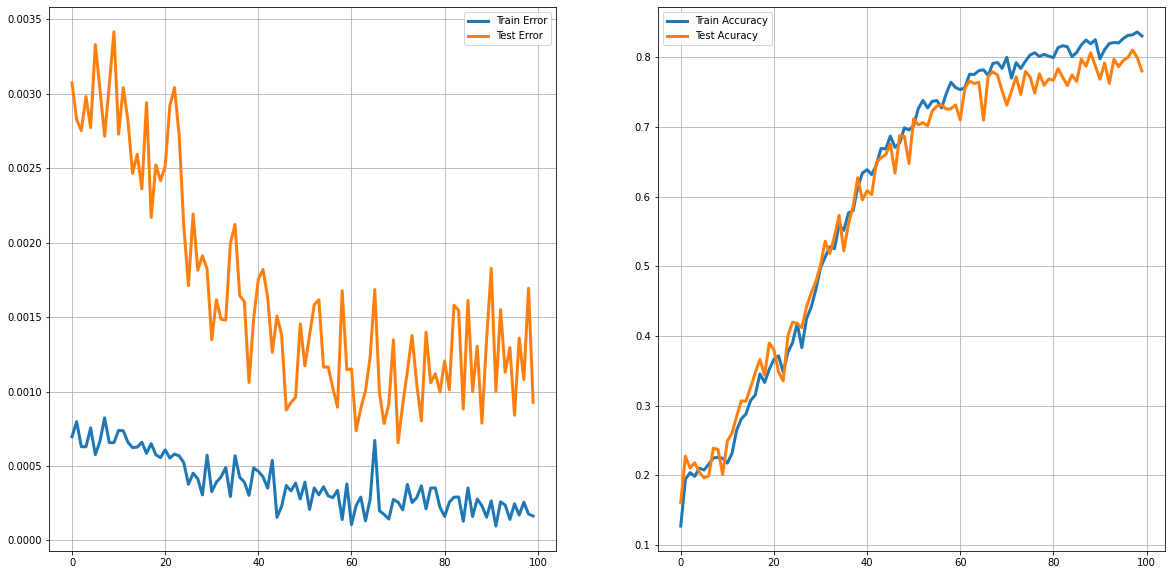

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error')
ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy')
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()
f.savefig("./trainTestCurve.png")